## Homework 3 (Project)

All group members met to discuss problems 2 and 3
### 2. The QCDS: Wanted dead and alive

#### a)

## Challenge code
 
 In this challenge you will be given the following functions: 
 - `create_Hamiltonian`: In which you build the Transverse Ising Hamiltonian for $N=4$ and a magnetic field intensity `h`. **You must complete this function.**
 - `model`: This function builds a general enough ansatz for the ground state. **You must complete this function.**
 - `train`: This function returns the eigenvalue after running the VQE algorithm. **You must complete this function.**
 
 ### Input
 
 As input to this problem, you are given:
 
 - `h` (`float`): Magnetic field intensity applied to the spin chain.
  
 ### Output
 
 This code will output a `float` corresponding to the energy of the ground state.
 
 If your solution matches the correct one within the given tolerance specified in `check` (in this case it's an relative tolerance of `0.1`), the output will be `"Correct!"` Otherwise, you will receive a `"Wrong answer"` prompt.
 
 Good luck!
 ### Imports
 The cell below specifies the libraries you should use in this challenge. Run the cell to import the libraries. 

In [19]:
# Import Qiskit's Aer simulator package
from qiskit import Aer 

# Import a classical optimizer routine
# https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers
from qiskit_algorithms.optimizers import COBYLA

# Import function to construct conveniently parametrized entangling circuits for constructing ansatze
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal
from qiskit.circuit.library import TwoLocal

# Import the default Estimator and the BackendEstimator to automate collection of expectation values
# https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator
# https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.BackendEstimator
from qiskit.primitives import Estimator, BackendEstimator

# Import the VQE algorithm itself
# https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.minimum_eigensolvers.VQE
from qiskit_algorithms import VQE

# To enable simply constructing Hamilitonians as sums of Pauli Operators
# https://docs.quantum.ibm.com/api/qiskit/0.31/qiskit.opflow.primitive_ops.PauliOp
from qiskit.opflow.primitive_ops import PauliSumOp

In [20]:
# Import Azure provider functionality
from azure.quantum.qiskit import AzureQuantumProvider

# paste your Resource id here, not your SUBSCRIPTION ID
resource_id = "/subscriptions/64189476-7250-44a2-a7c3-c83d8f6ffc87/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/PHYS576-BookerHu"   

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
) 

# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
backend = Aer.get_backend('statevector_simulator')


# backend = provider.get_backend("ionq.simulator")

C:\Users\booker\AppData\Local\Temp\ipykernel_11232\3454145088.py:8: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "resource_id", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider (


In [21]:
import json
import numpy as np
from qiskit.opflow.primitive_ops import PauliSumOp

### Code
 Complete the code below. You might find the qiskit docs on VQE useful: https://qiskit.org/ecosystem/algorithms/tutorials/01_algorithms_introduction.html. You can choose any ansatz, optimizer, and estimator that you like. Feel free to use the VQE algorithm in qiskit to make your life easier.

This code works for any value of N, just change number_qubits

In [9]:
# Uneditable section #
number_qubits = 4

def create_Hamiltonian(h):
    """
    Function in charge of generating the Hamiltonian of the statement.

    Args:
        h (float): magnetic field strength

    Returns:
        Hamiltonian of the statement associated to h
    """
    # End of uneditable section #
    paulis = []
    weights = []    
    J=1

    # X
    for j in range(number_qubits):
        paulis.append('I'*j + 'X' + 'I'*(number_qubits-j-1))
        weights.append(-h)

    # ZZ
    for j in range(number_qubits-1):
        paulis.append('I'*j + 'ZZ' + 'I'*(number_qubits-j-2))
        weights.append(-J)

    paulis.append('Z' + 'I'*(number_qubits-2) + 'Z')
    weights.append(-J)    

    # Create Hamiltonian
    pauli_opc = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]
    hamiltonian = PauliSumOp.from_list([ op for op in pauli_opc ])
    print('Hamiltonian:\n',hamiltonian, '\n')
    # Put your code here #
    return hamiltonian


# Uneditable section #
def ansatz():
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz to create the candidate ground state. These parameters will
    be optimized later.

    Returns:
        ansatz_circ (QuantumCircuit): A parameterized circuit used as ansatz for VQE.
    """

    # End of uneditable section #

    # Put your code here #

    entangler_map = []    

    for j in range(number_qubits-1):
        entangler_map.append(((j),(j+1)))

    entangler_map.append(((number_qubits-1),(0)))
        

    # Create circuit with one layer (reps = 1) of single qubit rotations ("rx", "ry", or "rz") with variable angles, followed by layer of entangling gates (controlled x (CNOT): "cx", controlled z: "cz", controlled rx with variable angle: "crx", ...).
    # skip_final_rotation_layer = False would append an extra round of single qubit-rotations after the entangling layer (same rotation axis as the first rotation layer)
    # setting parameter_prefix = "theta_x" makes it so the output will show the optimized angles as theta_x[0] = ...; this is helpful when there are many parameters of different types.
    ansatz_form = TwoLocal(number_qubits, 'ry', 'crx', entangler_map, insert_barriers=True, reps=1, skip_final_rotation_layer=True, parameter_prefix='theta_x')
    return ansatz_form

# Uneditable section #
def train(h):
    """
    In this function you must design a subroutine that returns the
    eigenvalue that best approximate the ground state.

    Args:
        h (float): magnetic field strength

    Returns:
        eigenvalue (float): eigenvalue that best approximate the ground state energy
    """

    # End of uneditable section #

    # Put your code here #

    optimizer = COBYLA(maxiter=4000, tol = 1e-5)

    # Select/define the estimator: Estimator() or BackendEstimator(backend)
    estimator = Estimator()
    #estimator = BackendEstimator(backend)

    # When using the BackendEstimator, you can use the .set_options method to specify the number of shots used to obtain a single expectation value
    #estimator.set_options(shots=10000)

    # Create an instance of the VQE module; use VQE(estimator, ansatz(), optimizer, initial_point = [...]) to specify initial parameter guesses
    vqe = VQE(estimator, ansatz(), optimizer)

    # Run the VQE
    result = vqe.compute_minimum_eigenvalue(create_Hamiltonian(h))
    print('Results of VQE optimization:\n',result, '\n')
    
    return result.eigenvalue

These functions are responsible for testing the solution. You will need to run the cell below. ***Do not modify the cell.***

In [10]:
def run(test_case_input: str) -> str:
    ins = json.loads(test_case_input)
    result = train(ins)
    return str(result)


def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-1
    ), "The expected value is not correct."

### Test cases
 Running the cell below will load the test cases. ***Do not modify the cell***.
 - input: 1.0
 	+ expected output: -5.226251859505506
 - input: 2.3
 	+ expected output: -9.66382463698038
 - input: 0.5
 	+ expected output: -4.271558410139714
 - input: 1.5
 	+ expected output: -6.760008550556145

In [11]:
test_cases = [['1.0', '-5.226251859505506'], ['2.3', '-9.66382463698038'], ['0.5', '-4.271558410139714'], ['1.5', '-6.760008550556145']]

### Solution testing
 Once you have run every cell above, including the one with your code, the cell below will test your solution. Run the cell. If you are correct for all of the test cases, it means your solutions is correct. Otherwise, you need to double check your work. ***Do not modify the cell below.***

In [12]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '1.0'...
Hamiltonian:
 -1.0 * XIII
- 1.0 * IXII
- 1.0 * IIXI
- 1.0 * IIIX
- 1.0 * ZZII
- 1.0 * IZZI
- 1.0 * IIZZ
- 1.0 * ZIIZ 

Results of VQE optimization:
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 618,
    'eigenvalue': -4.532455805102543,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001DFFDF82A00>,
    'optimal_parameters': {   ParameterVectorElement(theta_x[0]): -6.85944264689734,
                              ParameterVectorElement(theta_x[1]): -3.1415958025681174,
                              ParameterVectorElement(theta_x[2]): 5.823622877880907,
                              ParameterVectorElement(theta_x[5]): -3.141593211661439,
                              ParameterVectorElement(theta_x[3]): -3.141589689082453,
                              ParameterVectorElement(theta_x[4]): -6.0674252403777444,
                              ParameterVectorElement(theta_x[6]): -6.01308761853824

AssertionError: The expected value is not correct.

#### b)

Assessing practicality of implementation.{ Upgrade your code to work for any
value of N and characterize its performance using one or more hardware simulators.
Question: for what range of values of N a solution is feasible on these machines?

In [13]:
# Import Azure provider functionality
from azure.quantum.qiskit import AzureQuantumProvider

# paste your Resource id here, not your SUBSCRIPTION ID
resource_id = "/subscriptions/64189476-7250-44a2-a7c3-c83d8f6ffc87/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/PHYS576-BookerHu"   

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
) 



C:\Users\booker\AppData\Local\Temp\ipykernel_11232\2424900036.py:8: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "resource_id", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider (


In [14]:
# Uneditable section #
number_qubits = 2

def create_Hamiltonian(h):
    """
    Function in charge of generating the Hamiltonian of the statement.

    Args:
        h (float): magnetic field strength

    Returns:
        Hamiltonian of the statement associated to h
    """
    # End of uneditable section #
    paulis = []
    weights = []    
    J=1

    # X
    for j in range(number_qubits):
        paulis.append('I'*j + 'X' + 'I'*(number_qubits-j-1))
        weights.append(-h)

    # ZZ
    for j in range(number_qubits-1):
        paulis.append('I'*j + 'ZZ' + 'I'*(number_qubits-j-2))
        weights.append(-J)

    if number_qubits>2:
        paulis.append('Z' + 'I'*(number_qubits-2) + 'Z')
        weights.append(-J)    

    # Create Hamiltonian
    pauli_opc = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]
    hamiltonian = PauliSumOp.from_list([ op for op in pauli_opc ])
    print('Hamiltonian:\n',hamiltonian, '\n')
    # Put your code here #
    return hamiltonian


# Uneditable section #
def ansatz():
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz to create the candidate ground state. These parameters will
    be optimized later.

    Returns:
        ansatz_circ (QuantumCircuit): A parameterized circuit used as ansatz for VQE.
    """

    # End of uneditable section #

    # Put your code here #

    entangler_map = []    

    for j in range(number_qubits-1):
        entangler_map.append(((j),(j+1)))

    if number_qubits>2:
        entangler_map.append(((number_qubits-1),(0)))
        

    # Create circuit with one layer (reps = 1) of single qubit rotations ("rx", "ry", or "rz") with variable angles, followed by layer of entangling gates (controlled x (CNOT): "cx", controlled z: "cz", controlled rx with variable angle: "crx", ...).
    # skip_final_rotation_layer = False would append an extra round of single qubit-rotations after the entangling layer (same rotation axis as the first rotation layer)
    # setting parameter_prefix = "theta_x" makes it so the output will show the optimized angles as theta_x[0] = ...; this is helpful when there are many parameters of different types.
    ansatz_form = TwoLocal(number_qubits, 'ry', 'crx', entangler_map, insert_barriers=True, reps=1, skip_final_rotation_layer=True, parameter_prefix='theta_x')
    return ansatz_form

# Uneditable section #
def train(h):
    """
    In this function you must design a subroutine that returns the
    eigenvalue that best approximate the ground state.

    Args:
        h (float): magnetic field strength

    Returns:
        eigenvalue (float): eigenvalue that best approximate the ground state energy
    """

    # End of uneditable section #

    # Put your code here #

    optimizer = COBYLA(maxiter=1000, tol = 1e-4)
    # optimizer = SPSA(maxiter=100)
    # Select/define the estimator: Estimator() or BackendEstimator(backend)
    # estimator = Estimator()
    estimator = BackendEstimator(backend)

    # When using the BackendEstimator, you can use the .set_options method to specify the number of shots used to obtain a single expectation value
    estimator.set_options(shots=2000)

    # Create an instance of the VQE module; use VQE(estimator, ansatz(), optimizer, initial_point = [...]) to specify initial parameter guesses
    vqe = VQE(estimator, ansatz(), optimizer)

    # Run the VQE
    result = vqe.compute_minimum_eigenvalue(create_Hamiltonian(h))
    print('Results of VQE optimization:\n',result, '\n')
    
    return result.eigenvalue

From problem 1, know J=1, h=1 for 2 qubits should give -2. 

In [15]:
# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
backend = Aer.get_backend('statevector_simulator')
# backend = provider.get_backend("ionq.simulator")

In [16]:
# Use VQE to obtain an approximate value of the ground state energy
ground_state_energy = train(h=1)

# Output the final estimate
print('ground state energy = ', ground_state_energy, 'J')

Hamiltonian:
 -1.0 * XI
- 1.0 * IX
- 1.0 * ZZ 

Results of VQE optimization:
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 47,
    'eigenvalue': -1.8119999999999998,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001DFFDF2C400>,
    'optimal_parameters': {   ParameterVectorElement(theta_x[0]): -1.0368076846178926,
                              ParameterVectorElement(theta_x[2]): -4.701205470318946,
                              ParameterVectorElement(theta_x[1]): 7.346236579461934},
    'optimal_point': array([-1.03680768,  7.34623658, -4.70120547]),
    'optimal_value': -1.8119999999999998,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x000001DFFDE5D040>,
    'optimizer_time': 1.076887845993042} 

ground state energy =  -1.8119999999999998 J


Seems to be giving a reasonable answer on the Aer simulator with 2000 shots. Try on the ionq simulator

In [17]:
# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
# backend = Aer.get_backend('statevector_simulator')
backend = provider.get_backend("ionq.simulator")

In [18]:
# Use VQE to obtain an approximate value of the ground state energy
ground_state_energy = train(h=1)

# Output the final estimate
print('ground state energy = ', ground_state_energy, 'J')

Hamiltonian:
 -1.0 * XI
- 1.0 * IX
- 1.0 * ZZ 

........

KeyboardInterrupt: 

Worked with 2 qubits, but took a long time (~7 minutes). try with 3

In [ ]:
# Uneditable section #
number_qubits = 3

def create_Hamiltonian(h):
    """
    Function in charge of generating the Hamiltonian of the statement.

    Args:
        h (float): magnetic field strength

    Returns:
        Hamiltonian of the statement associated to h
    """
    # End of uneditable section #
    paulis = []
    weights = []    
    J=1

    # X
    for j in range(number_qubits):
        paulis.append('I'*j + 'X' + 'I'*(number_qubits-j-1))
        weights.append(-h)

    # ZZ
    for j in range(number_qubits-1):
        paulis.append('I'*j + 'ZZ' + 'I'*(number_qubits-j-2))
        weights.append(-J)

    if number_qubits>2:
        paulis.append('Z' + 'I'*(number_qubits-2) + 'Z')
        weights.append(-J)    

    # Create Hamiltonian
    pauli_opc = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]
    hamiltonian = PauliSumOp.from_list([ op for op in pauli_opc ])
    print('Hamiltonian:\n',hamiltonian, '\n')
    # Put your code here #
    return hamiltonian


# Uneditable section #
def ansatz():
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz to create the candidate ground state. These parameters will
    be optimized later.

    Returns:
        ansatz_circ (QuantumCircuit): A parameterized circuit used as ansatz for VQE.
    """

    # End of uneditable section #

    # Put your code here #

    entangler_map = []    

    for j in range(number_qubits-1):
        entangler_map.append(((j),(j+1)))

    if number_qubits>2:
        entangler_map.append(((number_qubits-1),(0)))
        

    # Create circuit with one layer (reps = 1) of single qubit rotations ("rx", "ry", or "rz") with variable angles, followed by layer of entangling gates (controlled x (CNOT): "cx", controlled z: "cz", controlled rx with variable angle: "crx", ...).
    # skip_final_rotation_layer = False would append an extra round of single qubit-rotations after the entangling layer (same rotation axis as the first rotation layer)
    # setting parameter_prefix = "theta_x" makes it so the output will show the optimized angles as theta_x[0] = ...; this is helpful when there are many parameters of different types.
    ansatz_form = TwoLocal(number_qubits, 'ry', 'crx', entangler_map, insert_barriers=True, reps=1, skip_final_rotation_layer=True, parameter_prefix='theta_x')
    return ansatz_form

# Uneditable section #
def train(h):
    """
    In this function you must design a subroutine that returns the
    eigenvalue that best approximate the ground state.

    Args:
        h (float): magnetic field strength

    Returns:
        eigenvalue (float): eigenvalue that best approximate the ground state energy
    """

    # End of uneditable section #

    # Put your code here #

    optimizer = COBYLA(maxiter=1000, tol = 1e-4)
    # optimizer = SPSA(maxiter=100)
    # Select/define the estimator: Estimator() or BackendEstimator(backend)
    # estimator = Estimator()
    estimator = BackendEstimator(backend)

    # When using the BackendEstimator, you can use the .set_options method to specify the number of shots used to obtain a single expectation value
    estimator.set_options(shots=2000)

    # Create an instance of the VQE module; use VQE(estimator, ansatz(), optimizer, initial_point = [...]) to specify initial parameter guesses
    vqe = VQE(estimator, ansatz(), optimizer)

    # Run the VQE
    result = vqe.compute_minimum_eigenvalue(create_Hamiltonian(h))
    print('Results of VQE optimization:\n',result, '\n')
    
    return result.eigenvalue

In [ ]:
# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
backend = Aer.get_backend('statevector_simulator')
# backend = provider.get_backend("ionq.simulator")

In [ ]:
# Use VQE to obtain an approximate value of the ground state energy
ground_state_energy = train(h=1)

# Output the final estimate
print('ground state energy = ', ground_state_energy, 'J')

Hamiltonian:
 -1.0 * XII
- 1.0 * IXI
- 1.0 * IIX
- 1.0 * ZZI
- 1.0 * IZZ
- 1.0 * ZIZ 

Results of VQE optimization:
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 72,
    'eigenvalue': -3.043,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x0000018EF4F4EC20>,
    'optimal_parameters': {   ParameterVectorElement(theta_x[2]): -3.285305923603375,
                              ParameterVectorElement(theta_x[3]): -3.3180137829821086,
                              ParameterVectorElement(theta_x[0]): 0.20402688154738347,
                              ParameterVectorElement(theta_x[1]): 3.892644696827786,
                              ParameterVectorElement(theta_x[4]): -6.423323289309053,
                              ParameterVectorElement(theta_x[5]): 2.980596641488416},
    'optimal_point': array([ 0.20402688,  3.8926447 , -3.28530592, -3.31801378, -6.42332329,
        2.98059664]),
    'optimal_value': -3.043,
    'optimizer_evals': 

In [ ]:
# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
# backend = Aer.get_backend('statevector_simulator')
backend = provider.get_backend("ionq.simulator")

In [ ]:
# Use VQE to obtain an approximate value of the ground state energy
ground_state_energy = train(h=1)

# Output the final estimate
print('ground state energy = ', ground_state_energy, 'J')

Hamiltonian:
 -1.0 * XII
- 1.0 * IXI
- 1.0 * IIX
- 1.0 * ZZI
- 1.0 * IZZ
- 1.0 * ZIZ 

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Results of VQE optimization:
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 56,
    'eigenvalue': -3.2359999999999998,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x0000018EF4C4A9E0>,
    'optimal_parameters': {   ParameterVectorElement(theta_x[5]): 5.242820551406008,
                              ParameterVectorElement(theta_x[3]): -2.6791160053995555,
      

Reasonably close to the Aer value. Time ~12 minutes try 4.

In [51]:
# Uneditable section #
number_qubits = 4

def create_Hamiltonian(h):
    """
    Function in charge of generating the Hamiltonian of the statement.

    Args:
        h (float): magnetic field strength

    Returns:
        Hamiltonian of the statement associated to h
    """
    # End of uneditable section #
    paulis = []
    weights = []    
    J=1

    # X
    for j in range(number_qubits):
        paulis.append('I'*j + 'X' + 'I'*(number_qubits-j-1))
        weights.append(-h)

    # ZZ
    for j in range(number_qubits-1):
        paulis.append('I'*j + 'ZZ' + 'I'*(number_qubits-j-2))
        weights.append(-J)

    if number_qubits>2:
        paulis.append('Z' + 'I'*(number_qubits-2) + 'Z')
        weights.append(-J)    

    # Create Hamiltonian
    pauli_opc = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]
    hamiltonian = PauliSumOp.from_list([ op for op in pauli_opc ])
    print('Hamiltonian:\n',hamiltonian, '\n')
    # Put your code here #
    return hamiltonian


# Uneditable section #
def ansatz():
    """
    To implement VQE you need an ansatz for the candidate ground state!
    Define here the VQE ansatz to create the candidate ground state. These parameters will
    be optimized later.

    Returns:
        ansatz_circ (QuantumCircuit): A parameterized circuit used as ansatz for VQE.
    """

    # End of uneditable section #

    # Put your code here #

    entangler_map = []    

    for j in range(number_qubits-1):
        entangler_map.append(((j),(j+1)))

    if number_qubits>2:
        entangler_map.append(((number_qubits-1),(0)))
        

    # Create circuit with one layer (reps = 1) of single qubit rotations ("rx", "ry", or "rz") with variable angles, followed by layer of entangling gates (controlled x (CNOT): "cx", controlled z: "cz", controlled rx with variable angle: "crx", ...).
    # skip_final_rotation_layer = False would append an extra round of single qubit-rotations after the entangling layer (same rotation axis as the first rotation layer)
    # setting parameter_prefix = "theta_x" makes it so the output will show the optimized angles as theta_x[0] = ...; this is helpful when there are many parameters of different types.
    ansatz_form = TwoLocal(number_qubits, 'ry', 'crx', entangler_map, insert_barriers=True, reps=1, skip_final_rotation_layer=True, parameter_prefix='theta_x')
    return ansatz_form

# Uneditable section #
def train(h):
    """
    In this function you must design a subroutine that returns the
    eigenvalue that best approximate the ground state.

    Args:
        h (float): magnetic field strength

    Returns:
        eigenvalue (float): eigenvalue that best approximate the ground state energy
    """

    # End of uneditable section #

    # Put your code here #

    optimizer = COBYLA(maxiter=1000, tol = 1e-4)
    # optimizer = SPSA(maxiter=100)
    # Select/define the estimator: Estimator() or BackendEstimator(backend)
    # estimator = Estimator()
    estimator = BackendEstimator(backend)

    # When using the BackendEstimator, you can use the .set_options method to specify the number of shots used to obtain a single expectation value
    estimator.set_options(shots=2000)

    # Create an instance of the VQE module; use VQE(estimator, ansatz(), optimizer, initial_point = [...]) to specify initial parameter guesses
    vqe = VQE(estimator, ansatz(), optimizer)

    # Run the VQE
    result = vqe.compute_minimum_eigenvalue(create_Hamiltonian(h))
    print('Results of VQE optimization:\n',result, '\n')
    
    return result.eigenvalue

In [52]:
# Set your backend of choice using Aer.get_backend(...) or provider.get_backend(...)
# backend = Aer.get_backend('statevector_simulator')
backend = provider.get_backend("ionq.simulator")

In [53]:
# Use VQE to obtain an approximate value of the ground state energy
ground_state_energy = train(h=1)

# Output the final estimate
print('ground state energy = ', ground_state_energy, 'J')

Hamiltonian:
 -1.0 * XIII
- 1.0 * IXII
- 1.0 * IIXI
- 1.0 * IIIX
- 1.0 * ZZII
- 1.0 * IZZI
- 1.0 * IIZZ
- 1.0 * ZIIZ 

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Results of VQE optimization:
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 83,
    'eigenvalue': -4.541,
    'optimal_circuit': <qiskit.circuit.li

Energy is a bit higher than expected here, and the calculation time is getting very long for N=4, >15 minutes. Seems like going much beyong 4 qubits isn't feasible. Maybe for a different classical optimizer?

### 3. (Project) Powering out on H2 

#### a)
All of the terms in the Hamiltonian of H2 preserve the number of electrons and the total z-component of spin. The system is also symmetric under reflection across the mid-point of the H-H bond: xi -> -xi, while yi; zi are unchanged, for each electron, i. Based on these considerations, deduce and explain which matrix elements of the Hamiltonian must be zero, in the occupation number basis defined above. Display your answer as a 16x16 matrix with zeros in all of the spots that must be zero, and blanks or some other symbol in the entries that need to be computed. Hint: you should have 20 nonzero matrix elements.

We can eliminate a bunch of the matrix elements with particle conservation and symmetry arguments. 

We're in the occupation number basis, |$\sigma\downarrow$,$\sigma\uparrow$,$\sigma*\downarrow$,$\sigma*\uparrow$⟩ so the 16 basis vectors correspond to 0 (1), 1 (4), 2 (6), 3 (4), and 4 (1) electrons. Since we can't create or destroy particles, the 16x16 matrix will be made up of 1x1, 4x4, 6x6, 4x4, and 1x1 blocks along the diagonal, with the other entries zero.


The Hamiltonian doesn't flip spins, so matrix elements that change total spin are 0 (for example, between |1,0,0,0⟩ and ⟨0,1,0,0|,etc).

Mirror symmetry M also commutes with the Hamiltonian. |$\sigma$⟩ is even under M, and |$\sigma*$⟩ is odd. So we have, for example, ⟨$\sigma$|HM|$\sigma*$⟩=-⟨$\sigma$|H|$\sigma*$⟩=⟨$\sigma$|MH|$\sigma*$⟩=⟨$\sigma$|H|$\sigma*$⟩. This means ⟨$\sigma$|H|$\sigma*$⟩=0. Generically, matrix elements between states with different mirror eigenvalues are zero.

The upshot is that the diagonal can be nonzero, but the only terms on the off diagonal that are allowed by particle conservation, spin conservation, and mirror symmetry are between |1,1,0,0⟩ and |0,0,1,1⟩, and between |1,0,0,1⟩ and |0,1,1,0⟩, so the matrix will look like:

\begin{pmatrix}

 x& & & & & & & & & & & & & & &  \\
 & x& 0& 0& 0& & & & & & & & & & &  \\
 & 0& x& 0& 0& & & & & & & & & & &  \\
 & 0& 0& x& 0& & & & & & & & & & &  \\
 & 0& 0& 0& x& & & & & & & & & & &  \\
 & & & & & x& 0& 0& 0& 0& x& & & & &  \\
 & & & & & 0& x& 0& 0& 0& 0& & & & &  \\
 & & & & & 0& 0& x& x& 0& 0& & & & &  \\
 & & & & & 0& 0& x& x& 0& 0& & & & &  \\
 & & & & & 0& 0& 0& 0& x& 0& & & & &  \\
 & & & & & x& 0& 0& 0& 0& x& & & & &  \\
 & & & & & & & & & & & x& 0& 0& 0&  \\
 & & & & & & & & & & & 0& x& 0& 0&  \\
 & & & & & & & & & & & 0& 0& x& 0&  \\
 & & & & & & & & & & & 0& 0& 0& x&  \\
 & & & & & & & & & & & & & & & x

\end{pmatrix}

Where x indicates a nonzero matrix element.

N.B. I'm numbering the states from |0,0,0,0⟩ to |1,1,1,1⟩, top to bottom, ie, |0,0,0,0⟩, |1,0,0,0⟩, |0,1,0,0⟩, etc. 

#### b)
Show the following relations hold:


- ⟨1,1,0,0|H|1,1,0,0⟩=2⟨$\sigma$|H1|$\sigma$⟩+⟨$\sigma\sigma$|Ve-e|$\sigma\sigma$⟩:
We sum over the single electron part, which ignores spin, so each electron gives one ⟨$\sigma$|H1|$\sigma$⟩ term. There is only one 2-electron term.

- ⟨0,0,1,1|H|1,1,0,0⟩=⟨$\sigma*\sigma*$|Ve-e|$\sigma\sigma$⟩:
Because |$\sigma$⟩ and |$\sigma*$⟩ are orthogonal, so there are no single electron terms here. The two electrons give one Ve-e term.

- ⟨1,0,1,0|H|1,0,1,0⟩=⟨$\sigma$|H1|$\sigma$⟩+⟨$\sigma*$|H1|$\sigma*$⟩+⟨$\sigma\sigma*$|Ve-e|$\sigma\sigma*$⟩-⟨$\sigma\sigma*$|Ve-e|$\sigma*\sigma$⟩: Single electron terms are from |$\sigma$⟩ and |$\sigma*$⟩ orthogonality. First Ve-e term is straightforward. The second term is from switching the two electrons (ie, electron 1 goes from $\sigma\downarrow$ to $\sigma*\downarrow$, and vice versa for electron 2). This gives a minus sign.

- ⟨1,0,0,1|H|1,0,0,1⟩=⟨$\sigma$|H1|$\sigma$⟩+⟨$\sigma*$|H1|$\sigma*$⟩+⟨$\sigma\sigma*$|Ve-e|$\sigma\sigma*$⟩: As above, but now we can't switch the electrons, because they have different spins. This eliminates the fourth term.

- ⟨0,1,1,0|H|1,0,0,1⟩=-⟨$\sigma\sigma*$|Ve-e|$\sigma*\sigma$⟩: There are no single particle terms, because the bra and ket are orthogonal. To get a nonzero term, we need to change |1,0,0,1⟩ to |0,1,1,0⟩. This can be done by exchanging electrons 1 and 2, where the spins are left the same. This gives a minus sign, so we get the single Ve-e term given.




#### c)
The steps above laid the groundwork for coding up the Hamiltonian by organizing
the calculation into manageable pieces. Using the results in App. D, write a function
to create the Hamiltonian in the occupation number basis, for a given interatomic
distance d, and decompose the matrix into a weighted sum of Pauli operators. The
`SparsePauliOp.from operator(A)` method may be useful here.

The rest of the terms given in 3c are used without proof, but the logic is pretty much the same as in part 3b. Basically, we get a number of single particle terms (depending on the number of electrons) which are straightforward, and then the two particle terms by choosing two electrons from the total number. It can also be possible to switch electrons 1 and 2 and still have the states overlap (as above), which gives a minus sign to the two particle term.

In [22]:
from qiskit.quantum_info.operators import Operator, Pauli
import numpy as np
from qiskit.quantum_info import SparsePauliOp
import math
from qiskit.circuit import Parameter

from qiskit.circuit.library import XXPlusYYGate

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
import json
import numpy as np

In [27]:
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import transpile

# paste your Resource id here, not your SUBSCRIPTION ID
resource_id = "/subscriptions/64189476-7250-44a2-a7c3-c83d8f6ffc87/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/PHYS576-BookerHu"

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
)

# Get the backend
backend = provider.get_backend("ionq.simulator")

C:\Users\booker\AppData\Local\Temp\ipykernel_11232\3382678122.py:8: DeprecationWarning: Consider passing "workspace" argument explicitly. 
                 The ability to initialize AzureQuantumProvider with arguments "resource_id", "location" is going to be deprecated in future versions.
  provider = AzureQuantumProvider (


In [23]:
# ham_occupation = np.zeros([16,16])
ham_occupation = np.eye(16)

ham_occupation[1,0]=1
ham_occupation[0,1]=1
ham_occupation
# hamiltonian = SparsePauliOp.from_operator(Operator(ham_occupation))
# hamiltonian

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [28]:

# single particle terms
def sig_H1(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    kin1=3*hstme*alpha
    kin2=hstme*(3*alpha-((alpha**2)*(d**2)))*(math.exp(-alpha*((d**2)/2)))

    term1=-2*esquared*math.sqrt((2*alpha)/math.pi)
    term2=-2*esquared*((math.erf(d*math.sqrt(2*alpha)))/d)
    term3=-2*esquared*((math.erf(d*((math.sqrt(2*alpha))/2)))/(d/2))*math.exp(-alpha*((d**2)/2))

    returnsum = (1/(2*(1+eta)))*(2*kin1 + 2*kin2 + 2*term1 + 2*term2 + 4*term3)
    
    # returnsum=(1/(2*(1+eta)))*(2*((3*hstme*alpha) + (-2*esquared*math.sqrt((2*alpha)/math.pi)) + (-2*esquared*((math.erf(d*math.sqrt(2*alpha)))/d)))  +  2*((hstme*(3*alpha-((alpha**2)*(d**2)))*(math.exp(-alpha*((d**2)/2)))) + (-2*esquared*((math.erf(d*((math.sqrt(2*alpha))/2)))/(d/2))*math.exp(-alpha*((d**2)/2)))))

    return returnsum

def sigstar_H1(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    kin1=3*hstme*alpha
    kin2=hstme*(3*alpha-((alpha**2)*(d**2)))*(math.exp(-alpha*((d**2)/2)))

    term1=-2*esquared*math.sqrt((2*alpha)/math.pi)
    term2=-2*esquared*((math.erf(d*math.sqrt(2*alpha)))/d)
    term3=-2*esquared*((math.erf(d*((math.sqrt(2*alpha))/2)))/(d/2))*math.exp(-alpha*((d**2)/2))

    returnsum = (1/(2*(1-eta)))*(2*kin1 - 2*kin2 + 2*term1 + 2*term2 - 4*term3)

    # returnsum=(1/(2*(1-eta)))*(2*((3*hstme*alpha) + (-2*esquared*math.sqrt((2*alpha)/math.pi)) + (-2*esquared*((math.erf(d*math.sqrt(2*alpha)))/d)))  -  2*((hstme*(3*alpha-((alpha**2)*(d**2)))*(math.exp(-alpha*((d**2)/2)))) + (-2*esquared*((math.erf(d*((math.sqrt(2*alpha))/2)))/(d/2))*math.exp(-alpha*((d**2)/2)))))

    return returnsum

# two particle terms - expanding out, will get four terms in the ket (AA, BB, BA, AB) with plus and minus signs depending on sigma/ sigmastar. For both sigma or both sigmastar, all types of terms contribute, for mixed ones, the AA|V|AB terms will cancel out

def sigmasigma_V(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    term1=2*esquared*np.sqrt(alpha/np.pi)
    term2=esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)
    term3=esquared*(math.erf(np.sqrt(alpha)*d)/d)
    term4=2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))

    returnsum=(1/((2*(1+eta))**2))*(2*term1 + 2*term4 + 8*term2 + 2*term3 +2*term4)

    # returnsum=(1/((2*(1+eta))**2))*(2*(2*esquared*np.sqrt(alpha/np.pi)) + 8*(esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)) + 2*(esquared*(math.erf(np.sqrt(alpha)*d)/d)) + 2*(2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))))

    return returnsum  

def sigmastarsigmastar_V(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    term1=2*esquared*np.sqrt(alpha/np.pi)
    term2=esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)
    term3=esquared*(math.erf(np.sqrt(alpha)*d)/d)
    term4=2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))

    returnsum=(1/((2*(1-eta))**2))*(2*term1 + 2*term4 - 8*term2 + 2*term3 +2*term4)

    # returnsum=(1/((2*(1-eta))**2))*(2*(2*esquared*np.sqrt(alpha/np.pi)) - 8*(esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)) + 2*(esquared*(math.erf(np.sqrt(alpha)*d)/d)) + 2*(2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))))

    return returnsum 

def sigmasigmastar_V(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    term1=2*esquared*np.sqrt(alpha/np.pi)
    term2=esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)
    term3=esquared*(math.erf(np.sqrt(alpha)*d)/d)
    term4=2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))

    returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*term1 - 2*term4 + 2*term3 - 2*term4)

    # returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*(2*esquared*np.sqrt(alpha/np.pi)) + 2*(esquared*(math.erf(np.sqrt(alpha)*d)/d)) - 2*(2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))))

    return returnsum 

def sigmasigmastarswitch_V(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    term1=2*esquared*np.sqrt(alpha/np.pi)
    term2=esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)
    term3=esquared*(math.erf(np.sqrt(alpha)*d)/d)
    term4=2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))

    returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*term1 - 2*term4 - 2*term3 + 2*term4)

    # returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*(2*esquared*np.sqrt(alpha/np.pi)) - 2*(esquared*(math.erf(np.sqrt(alpha)*d)/d)) + 2*(2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))))

    return returnsum 

def sigsigstarstar_V(d):
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    eta=math.exp((-alpha/2)*(d**2))

    term1=2*esquared*np.sqrt(alpha/np.pi)
    term2=esquared*((math.erf((np.sqrt(alpha)*d)/2))/(d/2))*np.exp(-alpha*(d**2)/2)
    term3=esquared*(math.erf(np.sqrt(alpha)*d)/d)
    term4=2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))

    returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*term1 + 2*term4 - 2*term3 - 2*term4)

    # returnsum=(1/((2*(1+eta))*(2*(1-eta))))*(2*(2*esquared*np.sqrt(alpha/np.pi)) - 2*(esquared*(math.erf(np.sqrt(alpha)*d)/d)) - 2*(2*esquared*np.sqrt(alpha/np.pi)*np.exp(-alpha*(d**2))))

    return returnsum 

def create_Hamiltonian(d):
    
    a0=0.529 #bohr radius in angstroms
    alpha=(8/(9*math.pi))*(a0**(-2))
    me=((0.511E6)/((3E8)**2))/((1E10)**2) #electron mass in (eV*s^2)/(Angstrom^2)
    hbar=6.582E-16 #hbar in eV*s
    hstme=(hbar**2)/(2*me) # in eV*(Angstrom^2)
    esquared=1970/137 #in eV*Angstroms

    ham_occupation = np.zeros([16,16])

    # zero particle state is just zero

    # one particle states

    ham_occupation[1,1]=sig_H1(d)
    ham_occupation[2,2]=sig_H1(d)
    ham_occupation[3,3]=sigstar_H1(d)
    ham_occupation[4,4]=sigstar_H1(d)

    # two particle states
    ham_occupation[5,5]=2*sig_H1(d) + sigmasigma_V(d)
    ham_occupation[6,6]=sig_H1(d) + sigstar_H1(d) + sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)
    ham_occupation[7,7]=sig_H1(d) + sigstar_H1(d) + sigmasigmastar_V(d)
    ham_occupation[8,8]=sig_H1(d) + sigstar_H1(d) + sigmasigmastar_V(d)
    ham_occupation[9,9]=sig_H1(d) + sigstar_H1(d) + sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)
    ham_occupation[10,10]=2*sigstar_H1(d) + sigmasigmastar_V(d)

    ham_occupation[7,8]=-sigmasigmastarswitch_V(d)
    ham_occupation[8,7]=-sigmasigmastarswitch_V(d)
    ham_occupation[5,10]=sigsigstarstar_V(d)
    ham_occupation[10,5]=sigsigstarstar_V(d)

    # three particle states
    ham_occupation[11,11]=2*sig_H1(d) + sigstar_H1(d) + sigmasigma_V(d) + 2*sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)
    ham_occupation[12,12]=2*sig_H1(d) + sigstar_H1(d) + sigmasigma_V(d) + 2*sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)
    ham_occupation[13,13]=sig_H1(d) + 2*sigstar_H1(d) + sigmastarsigmastar_V(d) + 2*sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)
    ham_occupation[14,14]=sig_H1(d) + 2*sigstar_H1(d) + sigmastarsigmastar_V(d) + 2*sigmasigmastar_V(d) - sigmasigmastarswitch_V(d)

    #four particle state
    ham_occupation[15,15]=2*sig_H1(d) + 2*sigstar_H1(d) + sigmasigma_V(d) + sigmastarsigmastar_V(d) + 4*sigmasigmastar_V(d) - 2*sigmasigmastarswitch_V(d)

    ham_occupation = ham_occupation + (esquared/d)*np.eye(16) #nuc-nuc term

    hamiltonian = SparsePauliOp.from_operator(Operator(ham_occupation))
    # print('Hamiltonian:\n',ham_occupation, '\n')
    # print('Hamiltonian:\n',hamiltonian, '\n')
    # Put your code here #
    return hamiltonian



def ansatz():
   
    angle = Parameter("angle")  # undefined number
 
    # Create and optimize circuit once
    qc = QuantumCircuit(4)
    qc.x(0)
    qc.x(1)
    qc.append(XXPlusYYGate(angle,beta=np.pi/2),{0,2})
    # qc.rxx(angle,0,2)
    qc.cx(2,1)
    qc.cx(2,3)
    
    ansatz_form = qc


    # number_qubits = 4
    # entangler_map = []    

    # for j in range(number_qubits-1):
    #     entangler_map.append(((j),(j+1)))

    # if number_qubits>2:
    #     entangler_map.append(((number_qubits-1),(0)))
        

    # # Create circuit with one layer (reps = 1) of single qubit rotations ("rx", "ry", or "rz") with variable angles, followed by layer of entangling gates (controlled x (CNOT): "cx", controlled z: "cz", controlled rx with variable angle: "crx", ...).
    # # skip_final_rotation_layer = False would append an extra round of single qubit-rotations after the entangling layer (same rotation axis as the first rotation layer)
    # # setting parameter_prefix = "theta_x" makes it so the output will show the optimized angles as theta_x[0] = ...; this is helpful when there are many parameters of different types.
    # ansatz_form = TwoLocal(number_qubits, 'ry', 'crx', entangler_map, insert_barriers=True, reps=1, skip_final_rotation_layer=True, parameter_prefix='theta_x')
    return ansatz_form

# Uneditable section #
def train(h):
   

    optimizer = COBYLA(maxiter=1000, tol = 1e-4)
    # optimizer = SPSA(maxiter=100)
    # Select/define the estimator: Estimator() or BackendEstimator(backend)
    # estimator = Estimator()
    estimator = BackendEstimator(backend)

    # When using the BackendEstimator, you can use the .set_options method to specify the number of shots used to obtain a single expectation value
    # estimator.set_options(shots=2000)

    # Create an instance of the VQE module; use VQE(estimator, ansatz(), optimizer, initial_point = [...]) to specify initial parameter guesses
    vqe = VQE(estimator, ansatz(), optimizer)

    # Run the VQE
    result = vqe.compute_minimum_eigenvalue(create_Hamiltonian(h))
    # print('Results of VQE optimization:\n',result, '\n')
    
    return result.eigenvalue

In [29]:

Dz = np.linspace(.1,10,199)
energiez=[]
for d in Dz:
    energiez.append(train(d))

d:\anaconda\anaconda\envs\qc\lib\site-packages\azure\quantum\qiskit\backends\backend.py:146: UserWarning: Parameter 'shots' is subject to change in future versions. Please, use 'shots' parameter instead.
  warnings.warn(


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

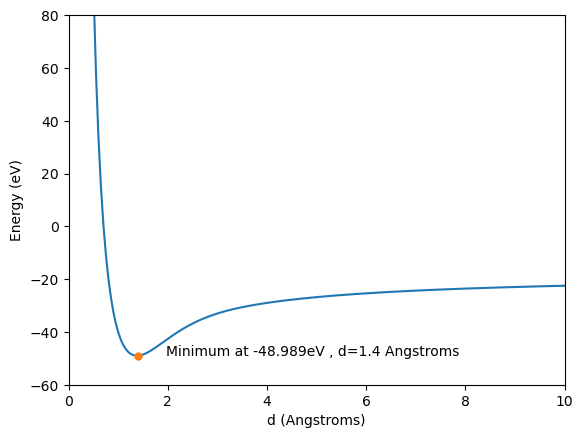

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Dz, energiez)
plt.ylim(-60, 80)
plt.xlim(0, 10)

emin= "% s" % round(min(energiez),3)
dmin= "% s" % round(Dz[energiez.index(min(energiez))],3)

label= 'Minimum at ' + emin + 'eV , d=' + dmin + ' Angstroms'

plt.plot(Dz[energiez.index(min(energiez))],min(energiez), marker='.', markersize=10)

plt.annotate(label, (Dz[energiez.index(min(energiez))],min(energiez)), textcoords="offset points", xytext=(20,0), ha='left') # horizontal alignment can be left, right or center


plt.xlabel('d (Angstroms)')
plt.ylabel('Energy (eV)')
plt.show()

This seems fairly reasonable. The energy blows up at small d, which is not surprising as the nucleii will start to get very close, costing a lot of Coulomb energy. There is a minimum at about 1.4 angstroms, roughly 3x the Bohr radius- this also makes sense, as each individual H atom should have a scale of roughly the Bohr radius. At larger d, the energy starts rising again (logorithmically, maybe?) and has an energy a bit under -20eV at large distances. This actually makes some sense as well- the hydrogen binding energy is -13.6eV, so if we have two copies of them far apart and not interacting, I would expect the energy to be roughly 2x that value, which is what we see.

Some thoughts on 3e. This should be from the van der Waals interaction, falling off as 1/r^6. This is a dipole-dipole interaction, so it wouldn't be captured by the spherical 1s orbitals. If we also had p orbitals, this would allow for the construction if electron distributions with a dipole moment, so should be able to capture this behavior. We were using 4 qubits, just considering 1s orbitals, with two atoms and two spins (2x2). Adding in 2p would require 3 more orbitals, so an additional 3x2x2=12, for a total of 16 qubits. Considering that the hamiltonian we used here was 2^4 = 16x16, this would give a hamiltonian which is 2^16= 65536x65536, which doesnt seem tractible.

Maybe if we just took a single p orbital? So an additional 4 qubits. We would want some variational parameter dealing with the length of the dipole, but this is a vector quantity so there needs to be four variational parameters. Not sure the best way to implement this though.